# Dealing with Noise

Taking derivatives is particularly challenging in the presence of noise, because the peaky, pointy nature of random variations can cause dramamtic local deviations of function slope. For more on the theory of noise, see [the math](https://pavelkomarov.com/spectral-derivatives/math.pdf)

In [1]:
import json, pandas, numpy as np
from numpy.polynomial import Polynomial as poly
from collections import deque
from matplotlib import pyplot
from scipy.fft import dct, dst
#from scipy.signal import savgol_filter, butter, sosfilt # experimented with some hybrids
from pynumdiff import savgoldiff
from IPython.display import HTML, display

import sys; sys.path.append('../specderiv') # so I can import specderiv code from a neighboring working directory
from specderiv import cheb_deriv, fourier_deriv
with open('alternative_chebyshev_derivative_methods.ipynb', 'r') as f: # Hacky but effective way to load code from another notebook
	notebook = json.load(f)
for cell in notebook['cells']:
	if cell['cell_type'] == 'code' and cell['source'][0].startswith('def cheb_deriv_via_fourier('):
		exec(''.join(cell['source']))
		break

### Measurement Noise

At equispaced points, as we use with the Fourier basis to achieve $O(N \log N)$ frequency transform, noise across measurements will look something like this:

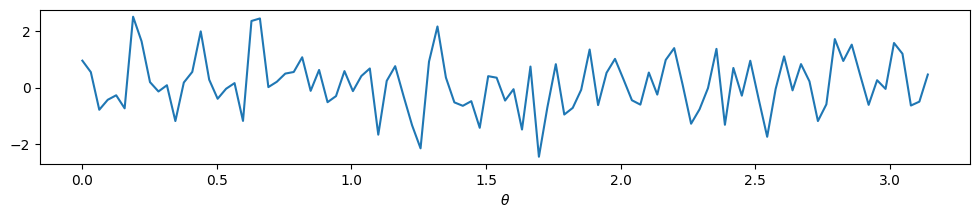

In [2]:
N = 100
noise = np.random.randn(N+1)

pyplot.figure(figsize=(12,2))
pyplot.plot((np.arange(N+1) * np.pi / N), noise)
pyplot.xlabel(r"$\theta$");

But in the case of measurement noise at cosine-spaced points, our noise wave will look something like the following in the $x$ domain (left-right inverted below to match the above), with noise spread out in the middle and squished at the edges:

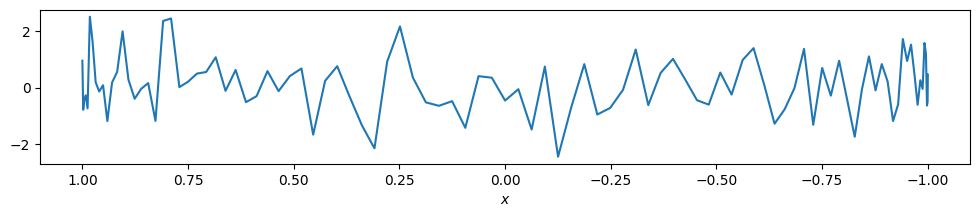

In [3]:
pyplot.figure(figsize=(12,2))
pyplot.plot(np.cos(np.arange(N+1) * np.pi / N), noise)
pyplot.gca().invert_xaxis()
pyplot.xlabel(r"$x$");

### Process Noise

In this case we expect the noise to look evenly-distributed across whichever domain and simply *be sampled* at different points. Sampling at cosine-spaced points looks like:

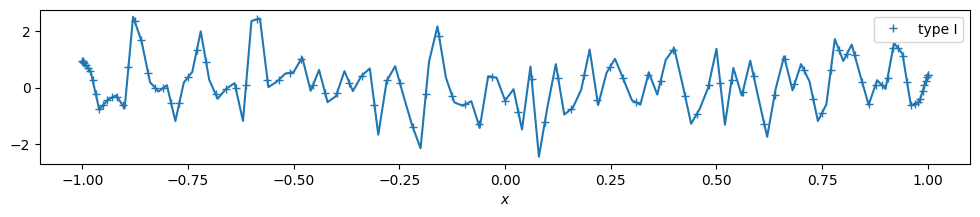

In [4]:
def cos_spaced_from_equi(y_n):
    """Interpolate the vector y_n, which is linspaced on [-1, 1], to find values at cosine-spaced points"""
    N = len(y_n) - 1
    x_lin = np.linspace(-1, 1, N+1)
    dx = x_lin[1] - x_lin[0]
    
    x_cos = np.cos(np.arange(N+1) * np.pi / N)
    i = 0
    c_n = []
    for x_n in x_cos[::-1]: # iterate low to high to fit my intuition
        while not x_lin[i] <= x_n <= x_lin[i+1]:
            i += 1
        c_n.append( ((x_n - x_lin[i]) * y_n[i+1] + (x_lin[i+1] - x_n) * y_n[i])/dx )
        
    return np.array(c_n[::-1]), x_cos

cos_noise, x_cos = cos_spaced_from_equi(noise)
pyplot.figure(figsize=(12,2))
pyplot.plot(np.linspace(-1, 1, len(noise)), noise)
pyplot.plot(x_cos, cos_noise, 'C0+', label='type I');
pyplot.xlabel(r"$x$")
pyplot.legend();

With this scheme, noise samples at the tightly-packed endpoints are no longer as statistically independent as noise samples in the spaced-out middle.

If we consider what this looks like in the implicit $\theta$ domain, we get a squish in the middle and spreading out at the edges:

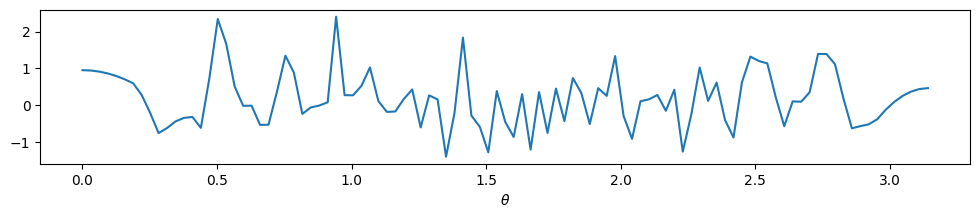

In [5]:
N = len(cos_noise) - 1
pyplot.figure(figsize=(12,2))
pyplot.plot((np.arange(N+1) * np.pi / N)[::-1], cos_noise)
pyplot.xlabel(r'$\theta$');

## Dealing with Noise Using the Fourier Basis

A classic FIR or IIR low-pass filter from Signal Processing, like a Butterworth Filter, works from one end of the signal toward the other "causally", dampening higher-frequencies with only *local*, past and present samples, literally by taking some weighted combination of a few local input values and adding a weighted combination of a few past output values. We analyze its effect on the frequency content of an equispaced signal using the Fourier transform of the filter's impulse response function.

But if we have the whole history of a signal, then there is no need to constrain ourselves locally; we can transform the entire thing to a Fourier basis representation, where modes correspond to frequencies. Hence a common noise removal strategy is:

1. FFT the signal
2. Zero out higher Fourier modes/coefficients
3. IFFT to recover the filtered signal

This achieves an *idealized* lowpass filter, where we get perfect cutoff, as opposed to a causal filter where we instead get power rolloff of, e.g., 20dB/decade.

Let's apply such a filter to a noisy version of the simple periodic signal from [the Fourier notebook](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/fourier.ipynb) and see how well we can recover it and its derivatives.

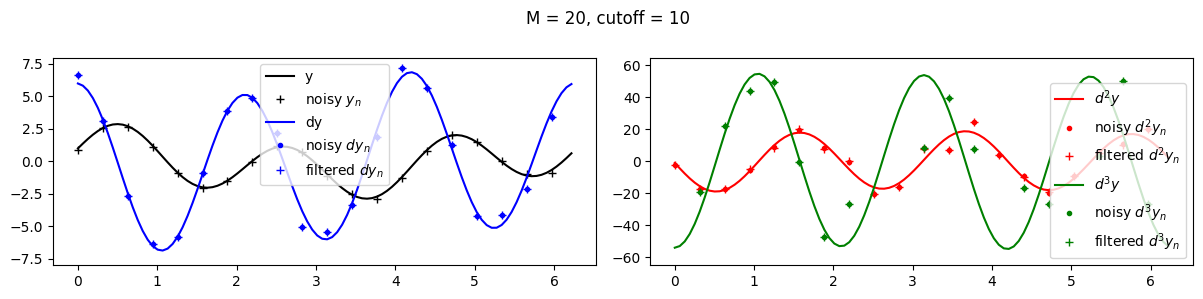

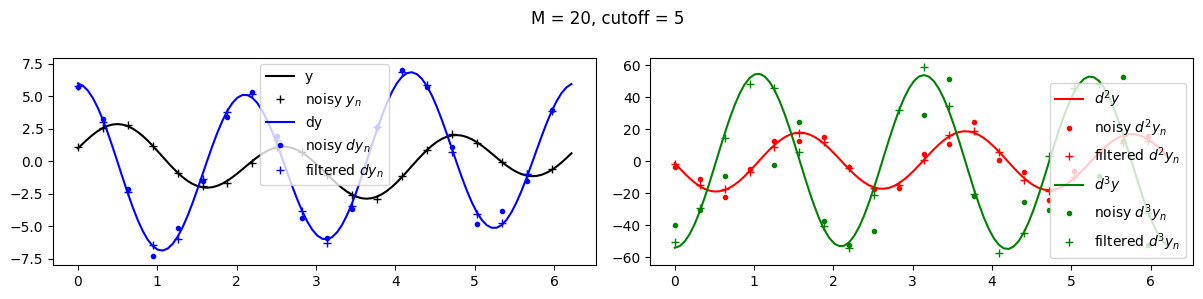

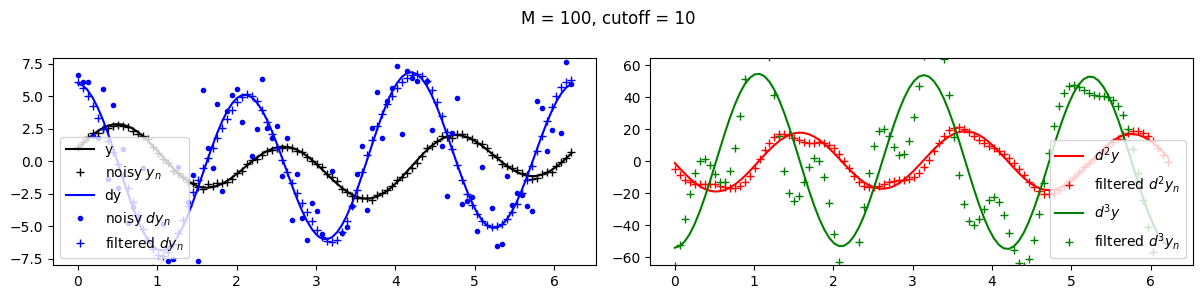

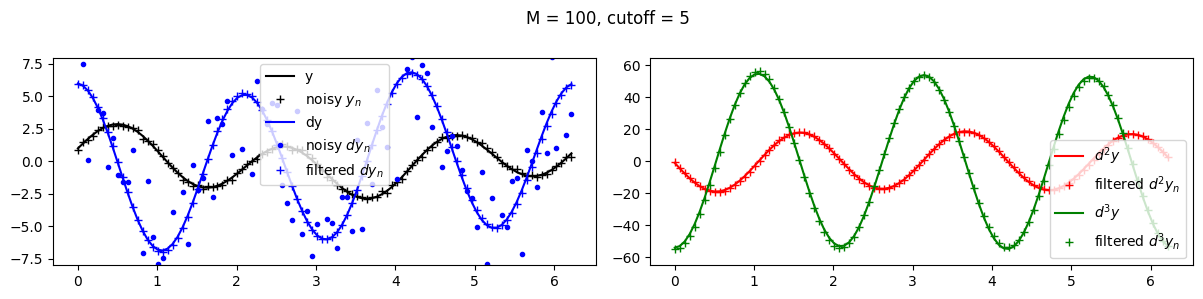

In [6]:
y = lambda th: np.cos(th) + 2*np.sin(3*th)
dy = lambda th: -np.sin(th) + 6*np.cos(3*th)
d2y = lambda th: -np.cos(th) - 18*np.sin(3*th)
d3y = lambda th: np.sin(th) - 54*np.cos(3*th)

th = np.linspace(0, 2*np.pi, 100, endpoint=False)
noise_scale = 0.1

L2_results = pandas.DataFrame(index=['M=20, cutoff=10', 'M=20, cutoff=5', 'M=100, cutoff=10', 'M=100, cutoff=5'], columns=['noisy', 'filtered'])
Linf_results = pandas.DataFrame(index=['M=20, cutoff=10', 'M=20, cutoff=5', 'M=100, cutoff=10', 'M=100, cutoff=5'], columns=['noisy', 'filtered'])

for M in (20, 100):
	for cutoff in (10, 5):
		th_n = np.linspace(0, 2*np.pi, M, endpoint=False)
		y_n = y(th_n)
		y_n_with_noise = y_n + noise_scale*np.random.randn(*th_n.shape) # add in some gaussian noise

		dy_n = [dy(th_n), d2y(th_n), d3y(th_n)]
		dy_n_with_noise = [fourier_deriv(y_n_with_noise, th_n, nu) for nu in range(1, 4)]
		dy_n_with_filter = [fourier_deriv(y_n_with_noise, th_n, nu, filter=lambda k: np.abs(k) < cutoff) for nu in range(1, 4)]

		fig, axes = pyplot.subplots(1, 2, figsize=(12,3))
		fig.suptitle(f"M = {M}, cutoff = {cutoff}")
		axes[0].plot(th, y(th), 'k', label='y')
		axes[0].plot(th_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
		axes[0].plot(th, dy(th), 'b', label='dy')
		axes[0].plot(th_n, dy_n_with_noise[0], 'b.', label=r'noisy $dy_n$')
		axes[0].plot(th_n, dy_n_with_filter[0], 'b+', label=r'filtered $dy_n$')
		axes[0].set_ylim((-8, 8))
		axes[0].legend()
		axes[1].plot(th, d2y(th), 'r', label=r'$d^2y$')
		if M == 20: axes[1].plot(th_n, dy_n_with_noise[1], 'r.', label=r'noisy $d^2y_n$')
		axes[1].plot(th_n, dy_n_with_filter[1], 'r+', label=r'filtered $d^2y_n$')
		axes[1].plot(th, d3y(th), 'g', label=r'$d^3y$')
		if M == 20: axes[1].plot(th_n, dy_n_with_noise[2], 'g.', label=r'noisy $d^3y_n$')
		axes[1].plot(th_n, dy_n_with_filter[2], 'g+', label=r'filtered $d^3y_n$')
		axes[1].set_ylim((-65,65))
		axes[1].legend()
		pyplot.tight_layout()

		L2_results.loc[f"M={M}, cutoff={cutoff}", 'noisy'] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_with_noise[nu]):.5g}" for nu in range(3)])
		L2_results.loc[f"M={M}, cutoff={cutoff}", 'filtered'] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_with_filter[nu]):.5g}" for nu in range(3)])
		Linf_results.loc[f"M={M}, cutoff={cutoff}", 'noisy'] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_with_noise[nu])):.5g}" for nu in range(3)])
		Linf_results.loc[f"M={M}, cutoff={cutoff}", 'filtered'] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_with_filter[nu])):.5g}" for nu in range(3)])

In [7]:
display(HTML(L2_results.style.set_caption("L2").set_properties(**{'text-align': 'left'}).to_html(escape=False)))
display(HTML(Linf_results.style.set_caption("L∞").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,noisy,filtered
"M=20, cutoff=10",1: 2.3842: 17.7313: 140.36,1: 2.3842: 17.6963: 140.36
"M=20, cutoff=5",1: 2.31252: 18.0013: 136.46,1: 1.0092: 3.87463: 15.298
"M=100, cutoff=10",1: 26.5952: 978.443: 36973,1: 3.5862: 26.1363: 205.48
"M=100, cutoff=5",1: 29.8342: 1164.43: 49529,1: 0.862432: 2.89443: 10.543


,noisy,filtered
"M=20, cutoff=10",1: 1.24012: 8.37233: 68.621,1: 1.24012: 8.12523: 68.621
"M=20, cutoff=5",1: 1.08332: 7.02443: 59.618,1: 0.374472: 1.42433: 5.227
"M=100, cutoff=10",1: 6.45982: 267.73: 8074.6,1: 0.817662: 5.42753: 40.801
"M=100, cutoff=5",1: 7.3862: 304.863: 11046,1: 0.191442: 0.58323: 2.0339


We can first observe filtering is *way* better than not filtering. The samples blow up so fast in the unfiltered ("noisy") case that it's not even practical to plot them past the first derivative. We can also see unfiltered noise is even more overwhelming when we include more samples, because decreased distance between them increases slopes. But including more samples is better for band separation of noise, so we can better filter the noise with larger $M$, even using the same cutoff frequencies.


## Dealing with Noise Using the Chebyshev Basis

We have to be a bit more conscientious when using non-Fourier modes to filter noise: If a basis function changes frequency over parts of its domain, e.g. like Chebyshev polynomials get steeper toward the edges of $[-1, 1]$, then that basis function will be better at representing high-frequency noise in some regions, and we won't get band-separation quite as cleanly as with the uniform Fourier basis.

Let's try to filter the different types of noise ("measurement" and "process") by keeping different numbers of modes, using different densities of sampling to try for better band separation. We'll use the classic test signal from [the Chebyshev notebook](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev.ipynb).

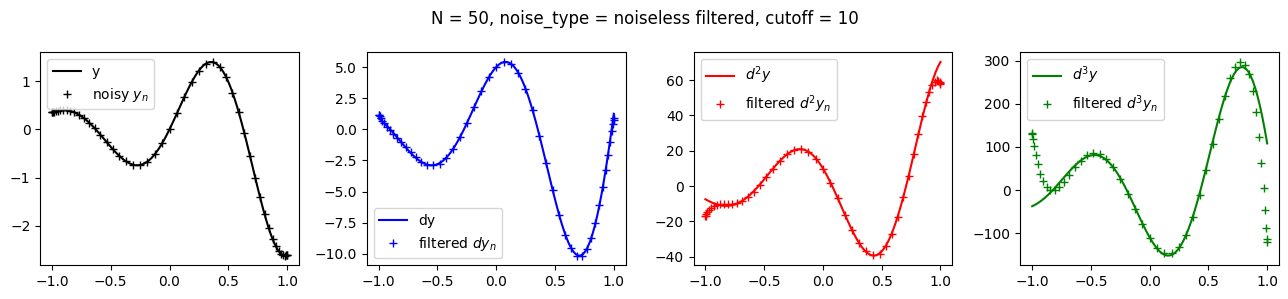

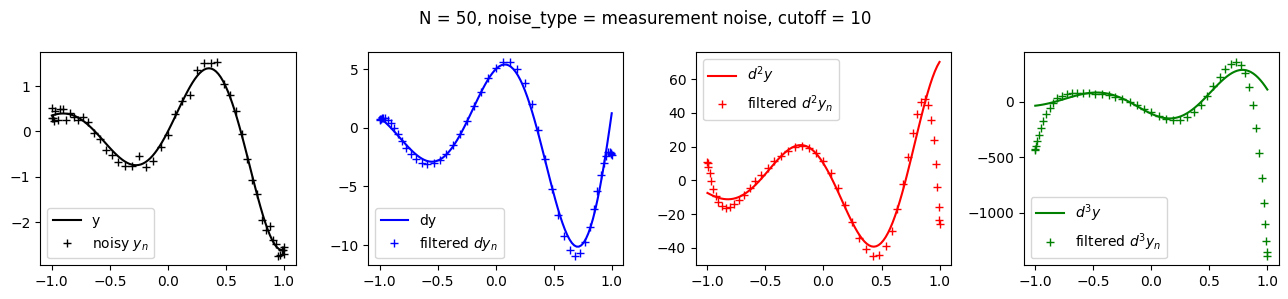

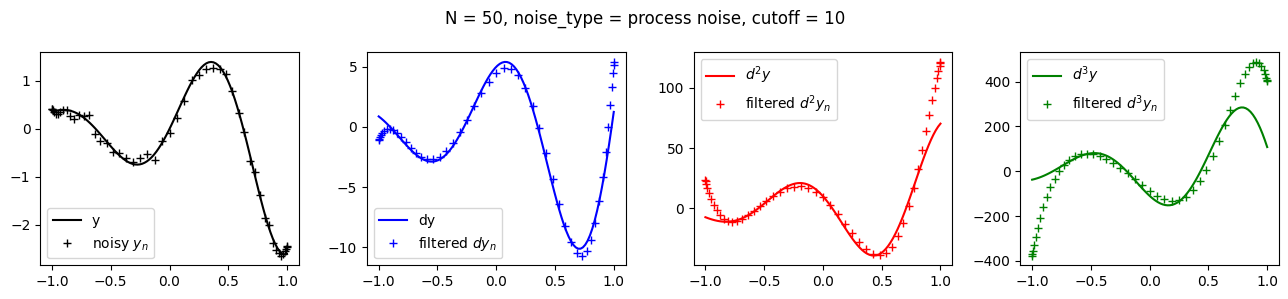

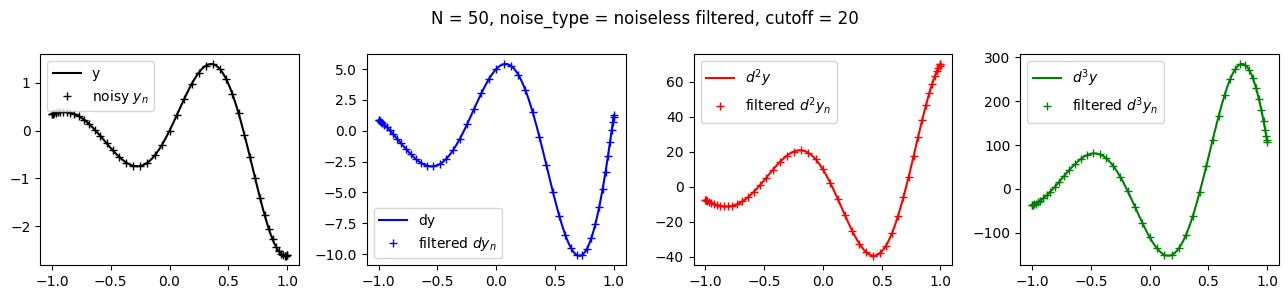

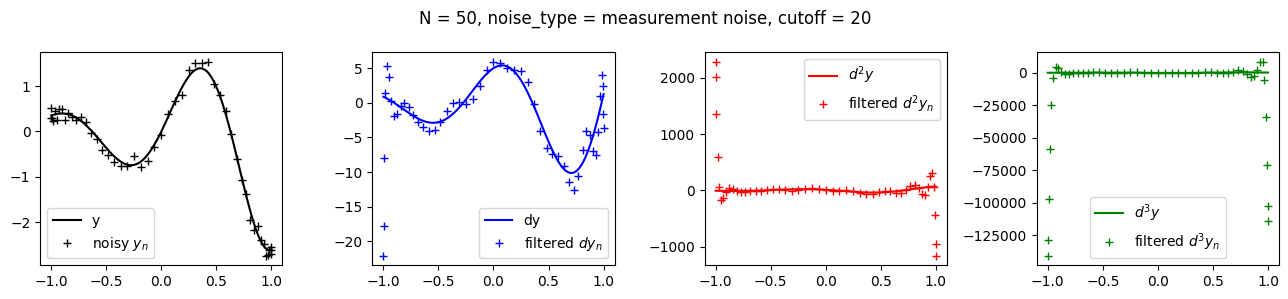

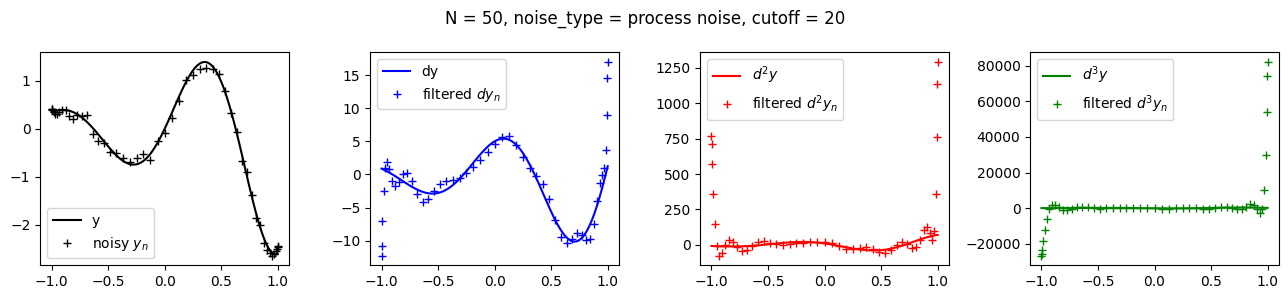

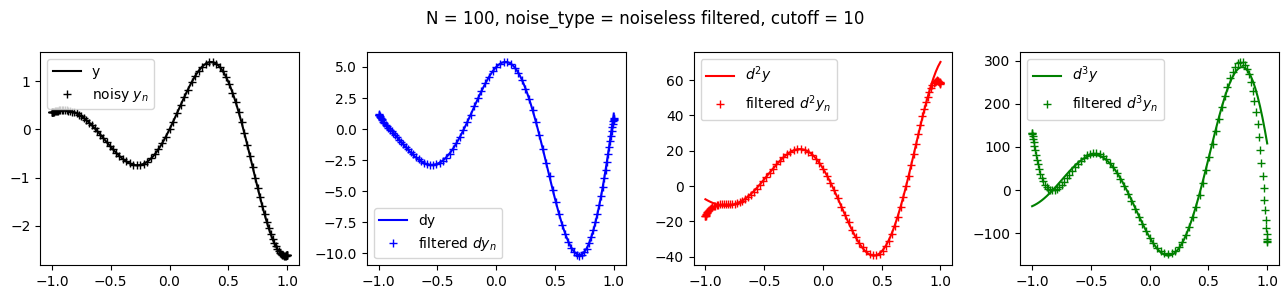

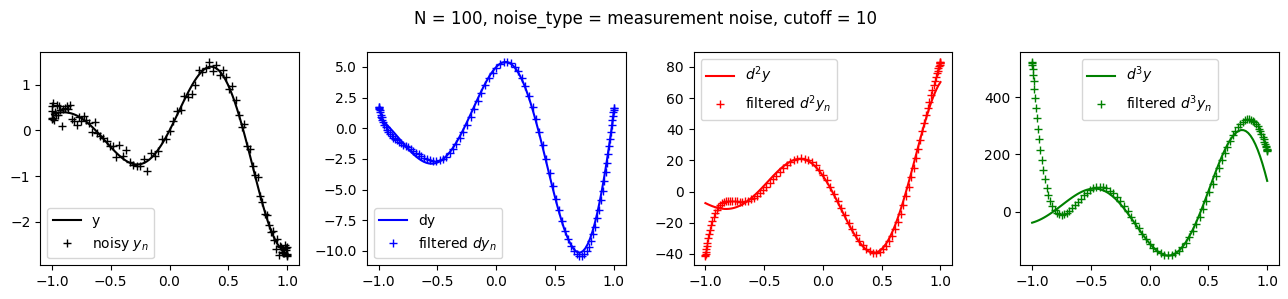

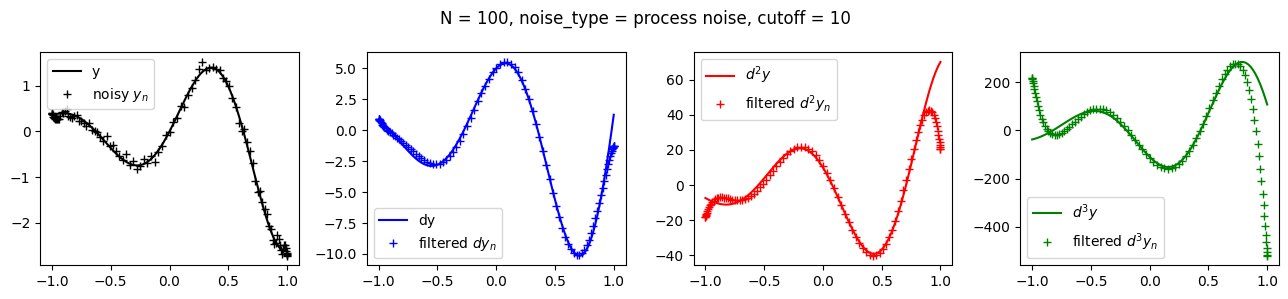

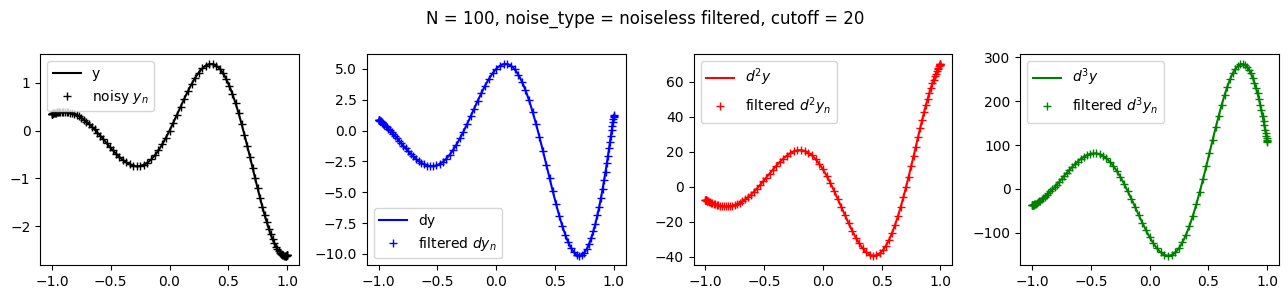

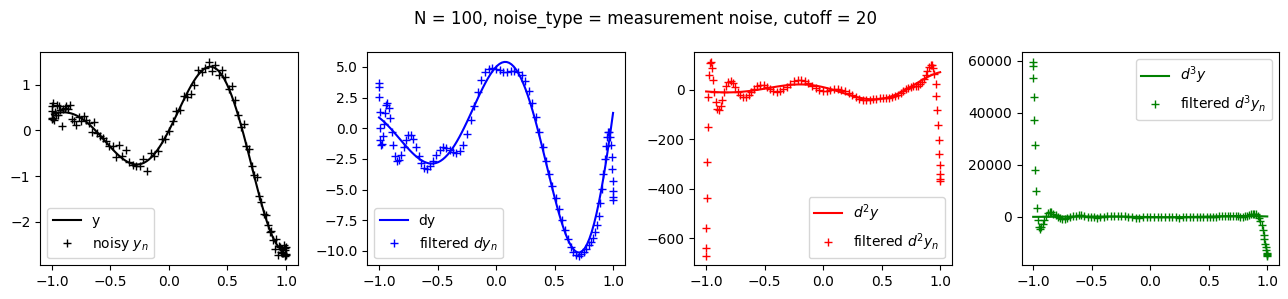

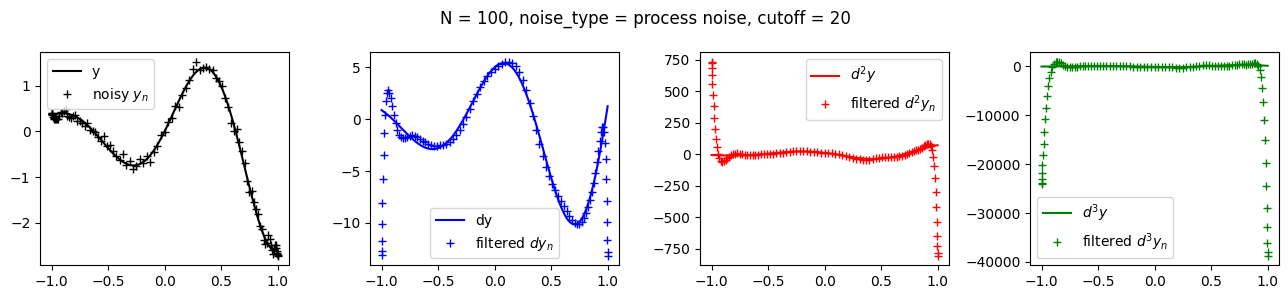

In [8]:
y = lambda x: np.exp(x) * np.sin(5*x)
dy = lambda x: 5*np.exp(x) * np.cos(5*x) + np.exp(x) * np.sin(5*x)
d2y = lambda x: 2*np.exp(x) * (5*np.cos(5*x) - 12*np.sin(5*x))
d3y = lambda x: -2*np.exp(x) * (37*np.sin(5*x) + 55*np.cos(5*x))
d4y = lambda x: 4*np.exp(x) * (119*np.sin(5*x) - 120*np.cos(5*x))

x = np.linspace(-1, 1, 100)
noise_scale = 0.1

L2_results = pandas.DataFrame()
Linf_results = pandas.DataFrame()

for N in (50, 100):
	equispaced_noise = np.random.randn(N+1)
	cos_noise, _ = cos_spaced_from_equi(equispaced_noise)
	for cutoff in (10, 20):
		x_n = np.cos(np.arange(N+1) * np.pi / N) # length N+1, in keeping with the usage of N in Trefethen.
		y_n = y(x_n)
		dy_n = [dy(x_n), d2y(x_n), d3y(x_n), d4y(x_n)]
		
		for noise_type in ["noiseless filtered", "measurement noise", "process noise", "measurement noise<br/>filtered", "process noise<br/>filtered"]:
			noise = equispaced_noise if "measurement" in noise_type else cos_noise if "process" in noise_type else 0
			
			y_n_with_noise = y_n + noise_scale*noise#; y_n_with_noise = savgol_filter(y_n_with_noise, 15, 4)

			filter = (lambda k: np.abs(k) < cutoff) if "filtered" in noise_type else None
			dy_n_computed = [cheb_deriv_via_fourier(y_n_with_noise, x_n, nu, filter=filter) for nu in range(1, 5)]
		
			if filter:
				fig, axes = pyplot.subplots(1, 4, figsize=(13,3))
				fig.suptitle(f"N = {N}, noise_type = {noise_type.split('<')[0]}, cutoff = {cutoff}")
				axes[0].plot(x, y(x), 'k', label='y')
				axes[0].plot(x_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
				axes[1].plot(x, dy(x), 'b', label='dy')
				axes[1].plot(x_n, dy_n_computed[0], 'b+', label=r'filtered $dy_n$')
				axes[2].plot(x, d2y(x), 'r', label=r'$d^2y$')
				axes[2].plot(x_n, dy_n_computed[1], 'r+', label=r'filtered $d^2y_n$')
				axes[3].plot(x, d3y(x), 'g', label=r'$d^3y$')
				axes[3].plot(x_n, dy_n_computed[2], 'g+', label=r'filtered $d^3y_n$')
				for i in range(4): axes[i].legend()
				pyplot.tight_layout()
	
			L2_results.loc[f"N={N}, cutoff={cutoff}", f"{noise_type}"] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n_computed[nu]-dy_n[nu]):.5g}" for nu in range(4)])
			Linf_results.loc[f"N={N}, cutoff={cutoff}", f"{noise_type}"] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n_computed[nu]-dy_n[nu])):.5g}" for nu in range(4)])

In [9]:
display(HTML(L2_results.style.set_caption("L2").set_properties(**{'text-align': 'left'}).to_html(escape=False)))
display(HTML(Linf_results.style.set_caption("Linf").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,noiseless filtered,measurement noise,process noise,measurement noisefiltered,process noisefiltered
"N=50, cutoff=10",1: 0.842692: 29.4793: 594.464: 7876.5,1: 255.212: 1.5571e+053: 6.6967e+074: 2.176e+10,1: 23.4952: 1406.73: 6.8185e+054: 2.9373e+08,1: 6.6722: 193.653: 3348.64: 37429,1: 9.4922: 138.633: 1184.84: 7447.4
"N=50, cutoff=20",1: 3.881e-082: 5.5089e-063: 0.000465764: 0.027401,1: 255.212: 1.5571e+053: 6.6967e+074: 2.176e+10,1: 23.4952: 1406.73: 6.8185e+054: 2.9373e+08,1: 33.5062: 3818.73: 2.8234e+054: 1.4877e+07,1: 30.6792: 21993: 1.3651e+054: 6.8791e+06
"N=100, cutoff=10",1: 1.14192: 40.2253: 816.074: 10863,1: 12972: 3.3954e+063: 5.5212e+094: 6.5407e+12,1: 70.0422: 121293: 2.9498e+074: 5.7399e+10,1: 3.20252: 98.6983: 1708.94: 19001,1: 6.56542: 144.213: 2071.24: 21289
"N=100, cutoff=20",1: 5.0825e-082: 7.2903e-063: 0.000621984: 0.036874,1: 12972: 3.3954e+063: 5.5212e+094: 6.5407e+12,1: 70.0422: 121293: 2.9498e+074: 5.7399e+10,1: 16.5242: 1566.63: 1.2653e+054: 7.3035e+06,1: 40.6482: 2516.33: 1.0584e+054: 3.5617e+06


,noiseless filtered,measurement noise,process noise,measurement noisefiltered,process noisefiltered
"N=50, cutoff=10",1: 0.374832: 12.233: 229.44: 2850,1: 192.842: 1.1263e+053: 4.8153e+074: 1.5444e+10,1: 7.90592: 852.313: 5.8501e+054: 2.4157e+08,1: 3.54692: 96.283: 1495.44: 15227,1: 4.14662: 51.2343: 339.174: 2748.7
"N=50, cutoff=20",1: 2.3346e-082: 3.1291e-063: 0.000249824: 0.01407,1: 192.842: 1.1263e+053: 4.8153e+074: 1.5444e+10,1: 7.90592: 852.313: 5.8501e+054: 2.4157e+08,1: 22.9482: 2291.33: 1.4055e+054: 6.4794e+06,1: 15.7422: 1221.93: 821144: 4.1519e+06
"N=100, cutoff=10",1: 0.374832: 12.233: 229.44: 2850,1: 1134.92: 2.8847e+063: 4.3928e+094: 4.8629e+12,1: 16.5272: 8486.13: 2.5596e+074: 4.9096e+10,1: 0.889272: 33.6913: 559.984: 5838.4,1: 2.49782: 49.7313: 628.924: 5722.9
"N=100, cutoff=20",1: 2.3346e-082: 3.1291e-063: 0.000249824: 0.014643,1: 1134.92: 2.8847e+063: 4.3928e+094: 4.8629e+12,1: 16.5272: 8486.13: 2.5596e+074: 4.9096e+10,1: 7.06542: 662.443: 596154: 3.3234e+06,1: 14.3912: 875.523: 388094: 1.386e+06


As with the Fourier case, we see that filtering is usually preferable to not filtering, although we are not doing as well in general. Maybe surprisingly, `cheb_deriv` has about equal trouble in the presence of process noise and measurement noise, at least when we filter out more modes. But filtering out fewer modes (higher cutoff) *usually* hurts performance less in the case of process noise.

Notice that we appear to need *more* modes to fit this function itself, because it's asymmetrical and more complicated, and this becomes a tradeoff with noise filtration. If we use 20 modes, we can represent this function no problem, but if we use 10, then *even in the noiseless case* we really can't, at least not at the edges. The interpolation ends up just *slightly* less steep than we need, because we're leaving off higher modes that could help us complete its representation, and this throws off subsequent derivatives ever more. But if we use 20 modes in the presence of noise, the noise slips through, especially affecting the interpolation at the edges of the domain, causing extra wobbles that kill us. I've tried to brainstorm ways around this in [Issue #14](https://github.com/pavelkomarov/spectral-derivatives/issues/14) without success. The Chebyshev basis fundamentally can't accomplish noise separation across the whole domain as uniformly as the Fourier basis.

I also tried combining a Savitzky-Golay prefilter with the Chebyshev method, but it often hurts performance, only some times improves it by a small margin, and does not solve the systematic blowup at the edges of the domain.

## Comparison with Savitzky-Golay + Gaussian Smoothing

It's worth comparing the above to a local method.

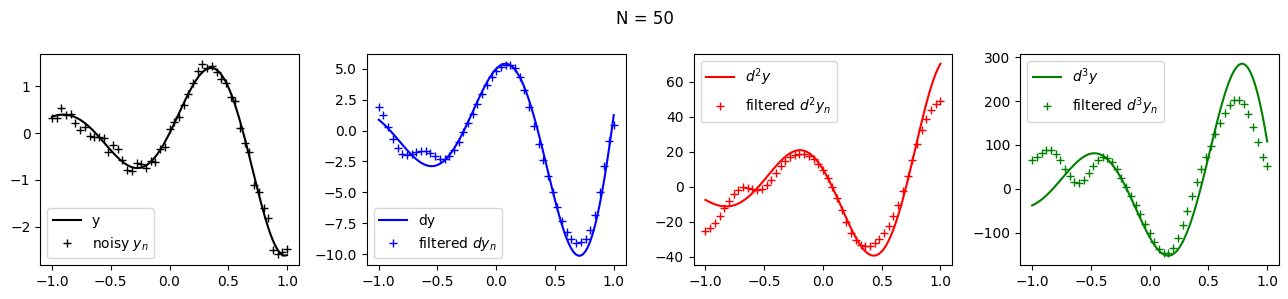

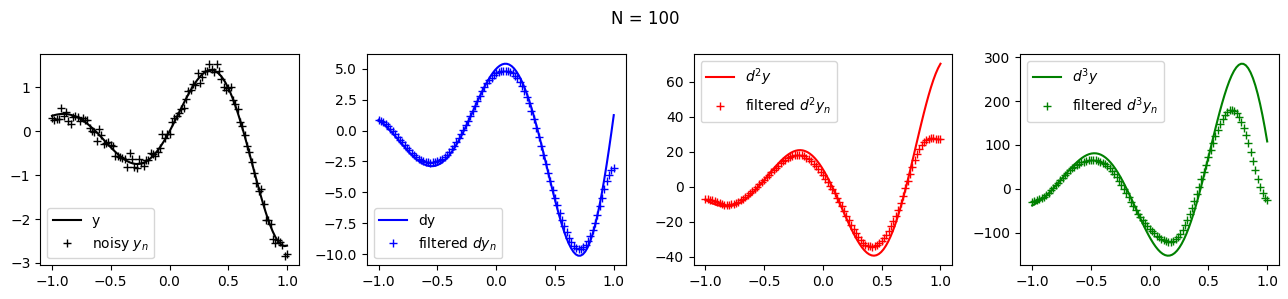

In [10]:
L_results = pandas.DataFrame()

for N in (50, 100):
	x_n = np.linspace(-1, 1, N+1)
	dx = x_n[1] - x_n[0]

	y_n = y(x_n)
	dy_n = [dy(x_n), d2y(x_n), d3y(x_n), d4y(x_n)]

	y_n_with_noise = y_n + noise_scale*np.random.randn(*x_n.shape)
	dy_n_with_filter = [savgoldiff(y_n_with_noise, dx, (3, N//5+1, N//5+1))[1]] # Floris' function only does one derivative at a time
	for nu in range(2, 5):
		dy_n_with_filter.append(savgoldiff(dy_n_with_filter[-1], dx, (3,  N//5+1, N//5+1))[1])

	fig, axes = pyplot.subplots(1, 4, figsize=(13,3))
	fig.suptitle(f"N = {N}")
	axes[0].plot(x, y(x), 'k', label='y')
	axes[0].plot(x_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
	axes[1].plot(x, dy(x), 'b', label='dy')
	axes[1].plot(x_n, dy_n_with_filter[0], 'b+', label=r'filtered $dy_n$')
	axes[2].plot(x, d2y(x), 'r', label=r'$d^2y$')
	axes[2].plot(x_n, dy_n_with_filter[1], 'r+', label=r'filtered $d^2y_n$')
	axes[3].plot(x, d3y(x), 'g', label=r'$d^3y$')
	axes[3].plot(x_n, dy_n_with_filter[2], 'g+', label=r'filtered $d^3y_n$')
	for i in range(4): axes[i].legend()
	pyplot.tight_layout()
    
	L_results.loc[f"N={N}", 'L2'] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_with_filter[nu]):.5g}" for nu in range(4)])
	L_results.loc[f"N={N}", 'L∞'] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_with_filter[nu])):.5g}" for nu in range(4)])

In [11]:
display(HTML(L_results.style.set_caption("savgoldiff").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,L2,L∞
N=50,1: 4.38332: 49.543: 391.084: 2176.6,1: 1.14572: 21.0643: 110.064: 821.73
N=100,1: 6.63542: 96.353: 648.664: 2750.4,1: 4.2522: 43.0463: 192.154: 853.27


It's also quite hard to make this work, and in many cases/with many parameter choices the 1st derivative fit does significantly worse than the spectral method. But this method suffers less from systematic blowup at the domain edges as we go to higher derivatives.

## Chebyshev Edge Blowup Still Occurs with Uniform Sampling or on Non-Canonical Domains

Since the [series-based Chebyshev derivative rule](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/alternative_chebyshev_derivative_methods.ipynb) allows sampling at any points, albeit at much greater computational cost ($O(N^3)$ rather than $O(N \log N)$), it's worth an experiment to see whether edge blowup is improved by not shrinking $\Delta x$ at the edges of the domain. Let's also use the domain $[0, 3]$ instead of $[-1, 1]$ only to point out that under the hood this has to be [shifted and scaled](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/alternative_chebyshev_derivative_methods.ipynb) to the canonical domain, because Chebyshev polynomials are only orthogonal on $[-1, 1]$.

It turns out Chebyshev polynomials have a harder time fitting and filtering the domain edges in this case too, indicating this effect is not purely due to the cosine-spaced sampling:

/Users/pavel/Code/spectral-derivatives/notebooks/../specderiv/specderiv.py:50: UserWarning: Your function is not sampled for the DCT-I, i.e. `t_n = np.cos(np.arange(N+1)*np.pi/N) * (b - a)/2 + (b + a)/2`.
			`cheb_deriv` using chebfit() and chebval() under the hood, which costs O(N^3) instead of O(N log N).
  warn("""Your function is not sampled for the DCT-I, i.e. `t_n = np.cos(np.arange(N+1)*np.pi/N) * (b - a)/2 + (b + a)/2`.
/Users/pavel/Code/spectral-derivatives/notebooks/../specderiv/specderiv.py:50: UserWarning: Your function is not sampled for the DCT-I, i.e. `t_n = np.cos(np.arange(N+1)*np.pi/N) * (b - a)/2 + (b + a)/2`.
			`cheb_deriv` using chebfit() and chebval() under the hood, which costs O(N^3) instead of O(N log N).
  warn("""Your function is not sampled for the DCT-I, i.e. `t_n = np.cos(np.arange(N+1)*np.pi/N) * (b - a)/2 + (b + a)/2`.
/Users/pavel/Code/spectral-derivatives/notebooks/../specderiv/specderiv.py:50: UserWarning: Your function is not sampled for the DCT-I, 

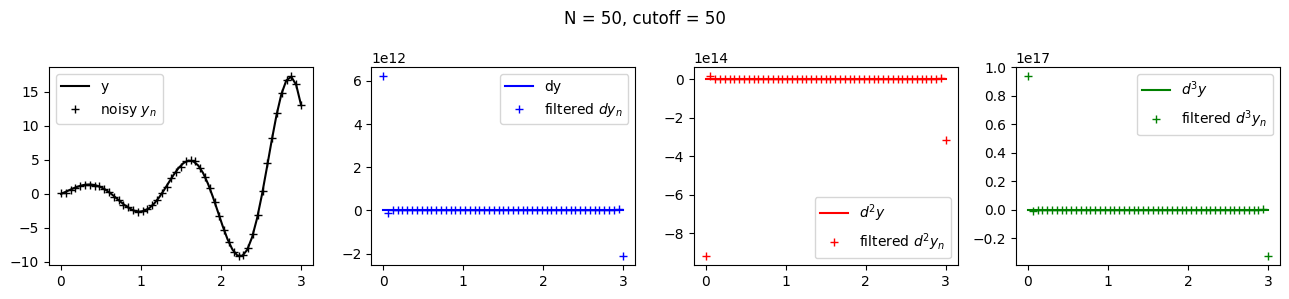

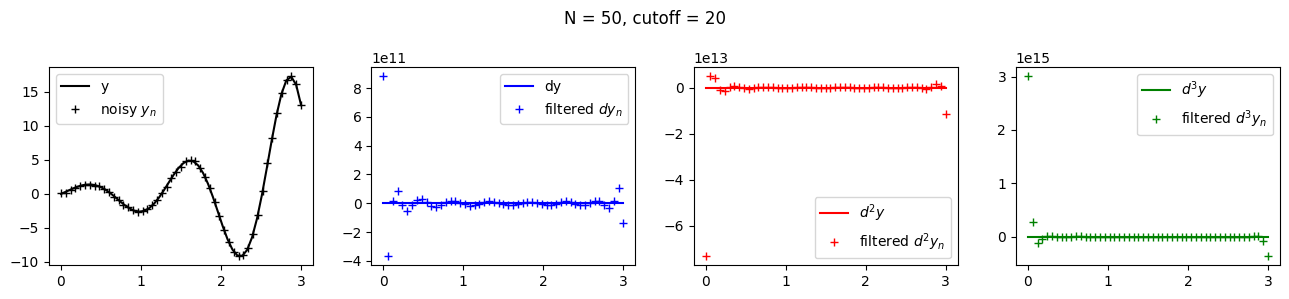

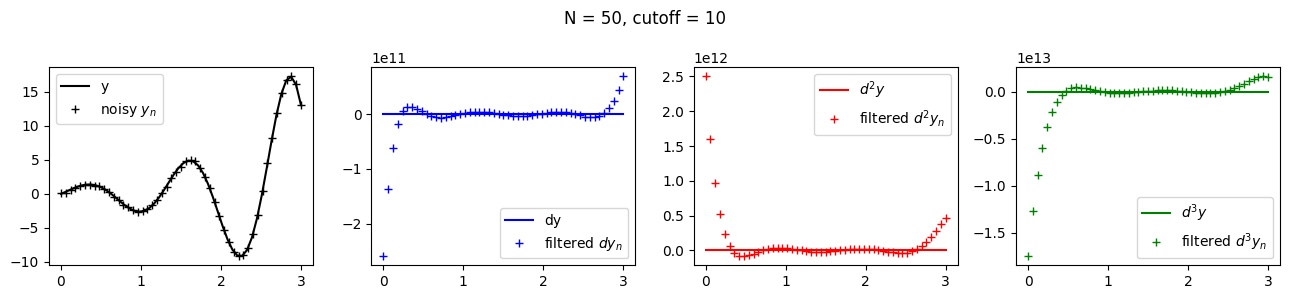

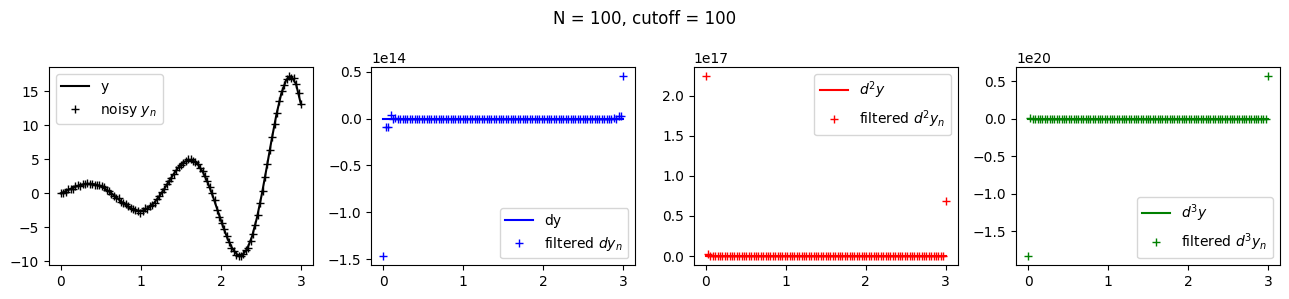

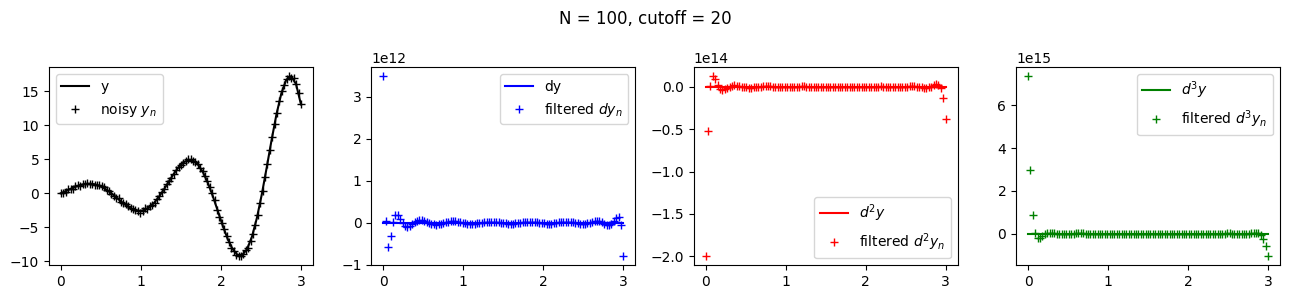

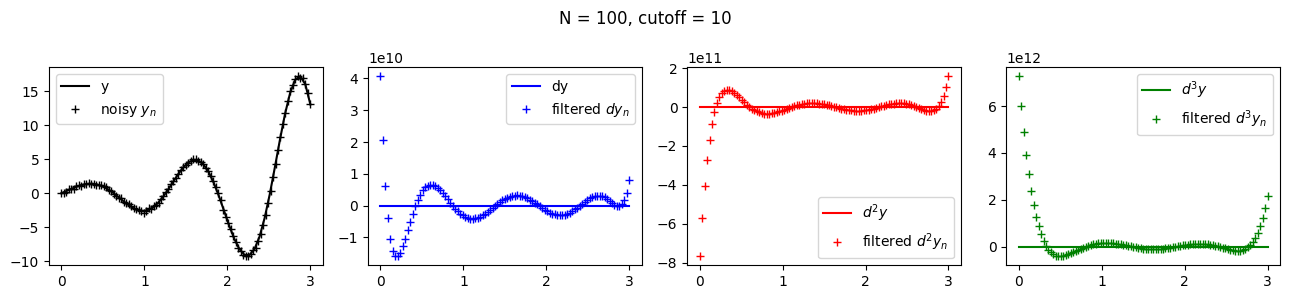

In [12]:
L2_results = pandas.DataFrame()
Linf_results = pandas.DataFrame()

for N in (50, 100):
	x_n = np.linspace(0, 3, N+1, endpoint=True) # length N+1, in keeping with the usage of N in Trefethen.
	equispaced_noise = np.random.randn(N+1)
	for cutoff in (N, 20, 10):
		y_n = y(x_n)
		dy_n = [dy(x_n), d2y(x_n), d3y(x_n), d4y(x_n)]

		y_n_with_noise = y_n + noise_scale*equispaced_noise
		dy_n_computed = [cheb_deriv(y_n_with_noise, x_n, nu, filter=lambda k: np.abs(k) < cutoff) for nu in range(1, 5)]
	
		fig, axes = pyplot.subplots(1, 4, figsize=(13,3))
		fig.suptitle(f"N = {N}, cutoff = {cutoff}")
		axes[0].plot(np.linspace(0,3), y(np.linspace(0,3)), 'k', label='y')
		axes[0].plot(x_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
		axes[1].plot(np.linspace(0,3), dy(np.linspace(0,3)), 'b', label='dy')
		axes[1].plot(x_n, dy_n_computed[0], 'b+', label=r'filtered $dy_n$')
		axes[2].plot(np.linspace(0,3), d2y(np.linspace(0,3)), 'r', label=r'$d^2y$')
		axes[2].plot(x_n, dy_n_computed[1], 'r+', label=r'filtered $d^2y_n$')
		axes[3].plot(np.linspace(0,3), d3y(np.linspace(0,3)), 'g', label=r'$d^3y$')
		axes[3].plot(x_n, dy_n_computed[2], 'g+', label=r'filtered $d^3y_n$')
		for i in range(4): axes[i].legend()
		pyplot.tight_layout()
	
		L2_results.loc[f"N={N}", f"cutoff={cutoff if cutoff != N else 'N'}"] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_computed[nu]):.5g}" for nu in range(4)])
		Linf_results.loc[f"N={N}", f"cutoff={cutoff if cutoff != N else 'N'}"] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_computed[nu])):.5g}" for nu in range(4)])

In [13]:
display(HTML(L2_results.style.set_caption("L2").set_properties(**{'text-align': 'left'}).to_html(escape=False)))
display(HTML(Linf_results.style.set_caption("Linf").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,cutoff=N,cutoff=20,cutoff=10
N=50,1: 6.5758e+122: 9.7411e+143: 9.9338e+164: 8.3478e+18,1: 9.8173e+112: 7.4447e+133: 3.0463e+154: 8.8887e+16,1: 3.1345e+112: 3.2634e+123: 2.4771e+134: 1.417e+14
N=100,1: 1.5426e+142: 2.3459e+173: 1.9176e+204: 1.0891e+23,1: 3.6686e+122: 2.1138e+143: 8.0956e+154: 2.3171e+17,1: 6.5724e+102: 1.1417e+123: 1.2725e+134: 9.4385e+13


,cutoff=N,cutoff=20,cutoff=10
N=50,1: 6.2209e+122: 9.2076e+143: 9.3802e+164: 7.873e+18,1: 8.8303e+112: 7.3189e+133: 3.0077e+154: 8.6762e+16,1: 2.5904e+112: 2.5046e+123: 1.7494e+134: 9.0718e+13
N=100,1: 1.4682e+142: 2.2416e+173: 1.8316e+204: 1.0398e+23,1: 3.4897e+122: 2.0004e+143: 7.3698e+154: 2.0154e+17,1: 4.0689e+102: 7.6781e+113: 7.286e+124: 4.5533e+13


Once again, using a filter tends to be better than not using one, but only barely in this case. The blowup is in fact much *worse* than when using DCT-I-compatible points, and it's still worst at the domain edges.

Interestingly, even in the presence of no noise, the fit gets markedly worse at the domain edges as $N$ increases and as the derivative order increases. This is a fundamental problem covered in [On the Errors Incurred Calculating Derivatives Using Chebyshev Polynomials](https://www.sciencedirect.com/science/article/pii/0021999192902743), related to the the fact "Tight coupling between coefficients enables propagation of errors from high frequency to low frequency modes." Essentially, any error in the value of a higher-order Chebyshev coefficient will affect [every-other lower-order coefficient](https://scicomp.stackexchange.com/questions/44939/chebyshev-series-derivative-in-terms-of-coefficients) in the derivative's series, and because lower-orders' coefficients are used to evaluate ever-lower-orders' coefficients [iteratively/recursively](https://github.com/numpy/numpy/blob/v2.2.0/numpy/polynomial/chebyshev.py#L874-L961) (in $O(N)$), the errors compound in a really nasty way. When found by least squares instead of by DCT, the coefficients start off significantly less accurate, and *less accurate coefficients cause larger errors where the polynomials are most sensitive, i.e. steepest, which is the domain edges.*

## Conclusion

Taking derivatives in the presence of noise is an ill-posed problem without a perfect solution. The promise of spectral methods is the ability to use global information to decide how to filter noise. But non-uniform bases are better at filtering noise in some regions of the domain compared to others, or may be prone to bad initial fits due to extra sensitivity in some regions. The Fourier basis is ideal for fitting and filtering noise uniformly across the domain.

Differentiation with the Chebyshev basis exhibits characteristic blowup at the edges of the domain and thus may not be suitable beyond first derivatives or very low noise levels. The Fourier basis exhibits no such weakness, and in fact its resilience to noise is one of its core strengths.